Below is our imports, parameters and the find function

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from numba import jit
from matplotlib.pyplot import figure

#alpha is the rate at which members of our population age up from young to old
alpha = 0.01
#beta is the infection rate. First input is for the young, second for the old. This is the same for most of these factors
beta = np.array((1, 1))
#gamma is the recovery rate
gamma = np.array((1/50, 1/50))
#mu is the death rate. Rows represent each infection state, while columns represent age
mu = np.array([[2e-4, 2e-4], [2e-4, 2e-4], [2e-4, 2e-4]])
birth_rate = 0.001

tau = 0.5
ND = MaxTime = 2 * 365
Number_Age_Classes = 2
timestep=0.0

@jit(nopython=True)
def find(condition):
    res, = np.nonzero(np.ravel(condition))
    return res

First we have the Tau Leap algorithm

In [2]:
def Stochastic_equations_Tau(INP): 
    Rate = np.zeros((16))
    #16 is the number of rules, 4 the number of infection states
    Pop_Change = np.zeros((16, 4, Number_Age_Classes))
    N = np.sum(INP[0]+INP[1]+INP[2])
    #rule 1: S to S (susceptible ageing)
    #subrule 1: Y to O
    Rate[0] = alpha * INP[0][0]
    Pop_Change[0,:] = np.array([[-1,+1], [0,0], [0,0], [0,0]])
    #rule 2: I+S to I+I (infection)
    #subrule 1: Y+Y (young infected by young)
    Rate[1] = (beta[0]**2) * INP[0][0] * INP[1][0] / N
    Pop_Change[1,:] = np.array([[-1,0], [+1,0], [0,0], [0,0]])
    #subrule 2: O+Y (young infected by old)
    Rate[2] = (beta[0]*beta[1]) * INP[1][1] * INP[0][0] / N
    Pop_Change[2,:] = np.array([[-1,0], [+1,0], [0,0], [0,0]])
    #subrule 3: Y+O (old infected by young)
    Rate[3] = (beta[0]*beta[1]) * INP[0][1] * INP[1][0] / N
    Pop_Change[3,:] = np.array([[0,-1], [0,+1], [0,0], [0,0]])
    #subrule 4: O+O (old infected by old)
    Rate[4] = (beta[1]**2) * INP[0][1] * INP[1][1] / N
    Pop_Change[4,:] = np.array([[0,-1], [0,+1], [0,0], [0,0]])
    #rule 3: S to D (susceptible death)
    #subrule 1: Y
    Rate[5] = mu[0][0] * INP[0][0]
    Pop_Change[5,:] = np.array([[-1,0], [0,0], [0,0], [+1,0]])
    #subrule 2: O
    Rate[6] = mu[0][1] * INP[0][1]
    Pop_Change[6,:] = np.array([[0,-1], [0,0], [0,0], [0,+1]])
    #rule 4: I to I (infected ageing)
    #subrule 1: Y to O
    Rate[7] = alpha * INP[1][0]
    Pop_Change[7,:] = np.array([[0,0], [-1,+1], [0,0], [0,0]])
    #rule 5: I to R (infected recovery)
    #subrule 1: Y
    Rate[8] = gamma[0] * INP[1][0]
    Pop_Change[8,:] = np.array([[0,0], [-1,0], [+1,0], [0,0]])
    #subrule 2: O
    Rate[9] = gamma[1] * INP[1][1]
    Pop_Change[9,:] = np.array([[0,0], [0,-1], [0,+1], [0,0]])
    #rule 6: I to D (infected death)
    #subrule 1: Y
    Rate[10] = mu[1][0] * INP[1][0]
    Pop_Change[10,:] = np.array([[0,0], [-1,0], [0,0], [+1,0]])
    #subrule 2: O
    Rate[11] = mu[1][1] * INP[1][1]
    Pop_Change[11,:] = np.array([[0,0], [0,-1], [0,0], [0,+1]])
    #rule 7: R to R (recovered ageing)
    #subrule 1; Y to O
    Rate[12] = alpha * INP[2][0]
    Pop_Change[12,:] = np.array([[0,0], [0,0], [-1,+1], [0,0]])
    #rule 8: R to D (recovered death)
    #subrule 1: Y
    Rate[13] = mu[2][0] * INP[2][0]
    Pop_Change[13,:] = np.array([[0,0], [0,0], [-1,0], [+1,0]])
    #subrule 2: O
    Rate[14] = mu[2][1] * INP[2][1]
    Pop_Change[14,:] = np.array([[0,0], [0,0], [0,-1], [0,+1]])
    #rule 9: Birth: 
    #subrule 1:
    Rate[15] = birth_rate * (INP[0]+INP[1]+INP[2])[1]
    Pop_Change[15,:] = np.array([[+1,0], [0,0], [0,0], [0,0]])
    r1 = np.random.rand() 
    r2 = np.random.rand()
    ts = -np.log(r1) / (np.sum(Rate));
    #decides what equation to use
    m1 = min(find(np.cumsum(Rate) >= np.sum(Rate) * r2));
    INP += Pop_Change[m1, :]
    return [INP]

def Stochastic_Iteration_Tau(INPUT):
    counter = 0
    S = np.array([[0, 0]])
    I = np.array([[0, 0]])
    R = np.array([[0, 0]])
    D = np.array([[0, 0]])
    for counter in T:
        S = np.concatenate((S, np.array([INPUT[0]])))
        I = np.concatenate((I, np.array([INPUT[1]])))
        R = np.concatenate((R, np.array([INPUT[2]])))
        D = np.concatenate((D, np.array([INPUT[3]])))
        INPUT = Stochastic_equations_Tau(INPUT)[0]
    return [S, I, R, D]

T = np.arange(0, ND, tau)

def Tau_Leap(INPUT):
    start = timer()
    T = np.arange(0, ND, tau)
    [S,I,R,D] = Stochastic_Iteration_Tau(INPUT)
    end = timer()
    completion_time = {end - start}
    return [T,S,I,R,D], sorted(completion_time)[0]

Next is Gillespie

In [3]:
def Stochastic_equations_Gillespie(INP,ts): 
    Rate = np.zeros((16))
    #16 is the number of rules, 4 the number of infection states
    Pop_Change = np.zeros((16, 4, Number_Age_Classes))
    N = np.sum(INP[0]+INP[1]+INP[2])
    #rule 1: S to S (susceptible ageing)
    #subrule 1: Y to O
    Rate[0] = alpha * INP[0][0]
    Pop_Change[0,:] = np.array([[-1,+1], [0,0], [0,0], [0,0]])
    #rule 2: I+S to I+I (infection)
    #subrule 1: Y+Y (young infected by young)
    Rate[1] = (beta[0]**2) * INP[0][0] * INP[1][0] / N
    Pop_Change[1,:] = np.array([[-1,0], [+1,0], [0,0], [0,0]])
    #subrule 2: O+Y (young infected by old)
    Rate[2] = (beta[0]*beta[1]) * INP[1][1] * INP[0][0] / N
    Pop_Change[2,:] = np.array([[-1,0], [+1,0], [0,0], [0,0]])
    #subrule 3: Y+O (old infected by young)
    Rate[3] = (beta[0]*beta[1]) * INP[0][1] * INP[1][0] / N
    Pop_Change[3,:] = np.array([[0,-1], [0,+1], [0,0], [0,0]])
    #subrule 4: O+O (old infected by old)
    Rate[4] = (beta[1]**2) * INP[0][1] * INP[1][1] / N
    Pop_Change[4,:] = np.array([[0,-1], [0,+1], [0,0], [0,0]])
    #rule 3: S to D (susceptible death)
    #subrule 1: Y
    Rate[5] = mu[0][0] * INP[0][0]
    Pop_Change[5,:] = np.array([[-1,0], [0,0], [0,0], [+1,0]])
    #subrule 2: O
    Rate[6] = mu[0][1] * INP[0][1]
    Pop_Change[6,:] = np.array([[0,-1], [0,0], [0,0], [0,+1]])
    #rule 4: I to I (infected ageing)
    #subrule 1: Y to O
    Rate[7] = alpha * INP[1][0]
    Pop_Change[7,:] = np.array([[0,0], [-1,+1], [0,0], [0,0]])
    #rule 5: I to R (infected recovery)
    #subrule 1: Y
    Rate[8] = gamma[0] * INP[1][0]
    Pop_Change[8,:] = np.array([[0,0], [-1,0], [+1,0], [0,0]])
    #subrule 2: O
    Rate[9] = gamma[1] * INP[1][1]
    Pop_Change[9,:] = np.array([[0,0], [0,-1], [0,+1], [0,0]])
    #rule 6: I to D (infected death)
    #subrule 1: Y
    Rate[10] = mu[1][0] * INP[1][0]
    Pop_Change[10,:] = np.array([[0,0], [-1,0], [0,0], [+1,0]])
    #subrule 2: O
    Rate[11] = mu[1][1] * INP[1][1]
    Pop_Change[11,:] = np.array([[0,0], [0,-1], [0,0], [0,+1]])
    #rule 7: R to R (recovered ageing)
    #subrule 1; Y to O
    Rate[12] = alpha * INP[2][0]
    Pop_Change[12,:] = np.array([[0,0], [0,0], [-1,+1], [0,0]])
    #rule 8: R to D (recovered death)
    #subrule 1: Y
    Rate[13] = mu[2][0] * INP[2][0]
    Pop_Change[13,:] = np.array([[0,0], [0,0], [-1,0], [+1,0]])
    #subrule 2: O
    Rate[14] = mu[2][1] * INP[2][1]
    Pop_Change[14,:] = np.array([[0,0], [0,0], [0,-1], [0,+1]])
    #rule 9: Birth: 
    #subrule 1:
    Rate[15] = birth_rate * (INP[0]+INP[1]+INP[2])[1]
    Pop_Change[15,:] = np.array([[+1,0], [0,0], [0,0], [0,0]])
    r1 = np.random.rand() 
    r2 = np.random.rand()
    ts = -np.log(r1) / (np.sum(Rate));
    #decides what equation to use
    m1 = min(find(np.cumsum(Rate) >= np.sum(Rate) * r2));
    INP += Pop_Change[m1, :]
    return [INP,ts]

def Stochastic_Iteration_Gillespie(INPUT):
    counter = 0
    ts = 0
    T = np.array([0])
    S = np.array([[0, 0]])
    I = np.array([[0, 0]])
    R = np.array([[0, 0]])
    D = np.array([[0, 0]])
    while T[counter] < ND:
        counter+=1
        T = np.concatenate((T, np.array([T[counter-1]+ts])))
        S = np.concatenate((S, np.array([INPUT[0]])))
        I = np.concatenate((I, np.array([INPUT[1]])))
        R = np.concatenate((R, np.array([INPUT[2]])))
        D = np.concatenate((D, np.array([INPUT[3]])))
        [INPUT,ts] = Stochastic_equations_Gillespie(INPUT,ts)
        counter+=1
        T = np.concatenate((T, np.array([T[counter-1]])))
        S = np.concatenate((S, np.array([INPUT[0]])))
        I = np.concatenate((I, np.array([INPUT[1]])))
        R = np.concatenate((R, np.array([INPUT[2]])))
        D = np.concatenate((D, np.array([INPUT[3]])))
        #print(T, S, I, R, D)
    return [T,S,I,R,D]

def Gillespie(INPUT):
    start = timer()
    [T,S,I,R,D] = Stochastic_Iteration_Gillespie(INPUT)
    end = timer()
    completion_time = {end - start}
    return [T,S,I,R,D], sorted(completion_time)[0]

Finally we have the HKO method

In [4]:
def Stochastic_equations_HKO(INP,ts): 
    Rate = np.zeros((9))
    SubRate = np.zeros((9, 4))
    #9 is the number of rules, 4 the max number of subrules, 4 the number of infection states
    Pop_Change = np.zeros((9, 4, 4, Number_Age_Classes))
    N = np.sum(INP[0]+INP[1]+INP[2])
    #rule 1: S to S (susceptible ageing)
    #subrule 1: Y to O
    SubRate[0, 0] = alpha * INP[0][0]
    Pop_Change[0, 0,:] = np.array([[-1,+1], [0,0], [0,0], [0,0]])
    #rule 2: I+S to I+I (infection)
    #subrule 1: Y+Y (young infected by young)
    SubRate[1, 0] = (beta[0]**2) * INP[0][0] * INP[1][0] / N
    Pop_Change[1, 0,:] = np.array([[-1,0], [+1,0], [0,0], [0,0]])
    #subrule 2: O+Y (young infected by old)
    SubRate[1, 1] = (beta[0]*beta[1]) * INP[1][1] * INP[0][0] / N
    Pop_Change[1, 1,:] = np.array([[-1,0], [+1,0], [0,0], [0,0]])
    #subrule 3: Y+O (old infected by young)
    SubRate[1, 2] = (beta[0]*beta[1]) * INP[0][1] * INP[1][0] / N
    Pop_Change[1, 2,:] = np.array([[0,-1], [0,+1], [0,0], [0,0]])
    #subrule 4: O+O (old infected by old)
    SubRate[1, 3] = (beta[1]**2) * INP[0][1] * INP[1][1] / N
    Pop_Change[1, 3,:] = np.array([[0,-1], [0,+1], [0,0], [0,0]])
    #rule 3: S to D (susceptible death)
    #subrule 1: Y
    SubRate[2, 0] = mu[0][0] * INP[0][0]
    Pop_Change[2, 0,:] = np.array([[-1,0], [0,0], [0,0], [+1,0]])
    #subrule 2: O
    SubRate[2, 1] = mu[0][1] * INP[0][1]
    Pop_Change[2, 1,:] = np.array([[0,-1], [0,0], [0,0], [0,+1]])
    #rule 4: I to I (infected ageing)
    #subrule 1: Y to O
    SubRate[3, 0] = alpha * INP[1][0]
    Pop_Change[3, 0,:] = np.array([[0,0], [-1,+1], [0,0], [0,0]])
    #rule 5: I to R (infected recovery)
    #subrule 1: Y
    SubRate[4, 0] = gamma[0] * INP[1][0]
    Pop_Change[4, 0,:] = np.array([[0,0], [-1,0], [+1,0], [0,0]])
    #subrule 2: O
    SubRate[4, 1] = gamma[1] * INP[1][1]
    Pop_Change[4, 1,:] = np.array([[0,0], [0,-1], [0,+1], [0,0]])
    #rule 6: I to D (infected death)
    #subrule 1: Y
    SubRate[5, 0] = mu[1][0] * INP[1][0]
    Pop_Change[5, 0,:] = np.array([[0,0], [-1,0], [0,0], [+1,0]])
    #subrule 2: O
    SubRate[5, 1] = mu[1][1] * INP[1][1]
    Pop_Change[5, 1,:] = np.array([[0,0], [0,-1], [0,0], [0,+1]])
    #rule 7: R to R (recovered ageing)
    #subrule 1; Y to O
    SubRate[6, 0] = alpha * INP[2][0]
    Pop_Change[6, 0,:] = np.array([[0,0], [0,0], [-1,+1], [0,0]])
    #rule 8: R to D (recovered death)
    #subrule 1: Y
    SubRate[7, 0] = mu[2][0] * INP[2][0]
    Pop_Change[7, 0,:] = np.array([[0,0], [0,0], [-1,0], [+1,0]])
    #subrule 2: O
    SubRate[7, 1] = mu[2][1] * INP[2][1]
    Pop_Change[7, 1,:] = np.array([[0,0], [0,0], [0,-1], [0,+1]])
    #rule 9: Birth: 
    #subrule 1:
    SubRate[8, 0] = birth_rate * (INP[0]+INP[1]+INP[2])[1]
    Pop_Change[8, 0,:] = np.array([[+1,0], [0,0], [0,0], [0,0]])
    for i in range(len(Rate)):
        Rate[i] = np.sum(SubRate[i])
    r1 = np.random.rand() 
    r2 = np.random.rand()
    ts = -np.log(r1) / (np.sum(Rate));
    #decides what equation to use
    m1 = min(find(np.cumsum(Rate) >= np.sum(Rate) * r2));
    if m1>0:
        r2 = r2 - (np.cumsum(Rate)[m1-1]/np.sum(Rate))
    m2 = min(find(np.cumsum(SubRate[m1]) >= np.sum(Rate) * r2));
    INP += Pop_Change[m1, m2, :]
    return [INP,ts]

def Stochastic_Iteration_HKO(INPUT):
    counter = 0
    ts = 0
    T = np.array([0])
    S = np.array([[0, 0]])
    I = np.array([[0, 0]])
    R = np.array([[0, 0]])
    D = np.array([[0, 0]])
    while T[counter] < ND:
        counter+=1
        #print(INPUT)
        T = np.concatenate((T, np.array([T[counter-1]+ts])))
        S = np.concatenate((S, np.array([INPUT[0]])))
        I = np.concatenate((I, np.array([INPUT[1]])))
        R = np.concatenate((R, np.array([INPUT[2]])))
        D = np.concatenate((D, np.array([INPUT[3]])))
        [INPUT,ts] = Stochastic_equations_HKO(INPUT,ts)
        counter+=1
        #print(INPUT)
        T = np.concatenate((T, np.array([T[counter-1]])))
        S = np.concatenate((S, np.array([INPUT[0]])))
        I = np.concatenate((I, np.array([INPUT[1]])))
        R = np.concatenate((R, np.array([INPUT[2]])))
        D = np.concatenate((D, np.array([INPUT[3]])))
    return [T,S,I,R,D]

def HKO(INPUT):
    start = timer()
    [T,S,I,R,D] = Stochastic_Iteration_HKO(INPUT)
    end = timer()
    completion_time = {end - start}
    return [T,S,I,R,D], sorted(completion_time)[0]

Below we make the tools for repeating these methods

In [5]:
def Method_repeater(method, repeats, INPUT):
    completion_times = []
    for i in range(repeats):
        method_execution = method(INPUT)
        completion_times = np.append(completion_times, [method_execution[-1]])
    return completion_times

Below is a method for us to run test on the methods. We include all our parameters in here and vary 

In [6]:
def Run_Experiment(pop_sizes, repeater_method, repeater_repeats):
    data = []
    averages = []
    upper_quart = []
    lower_quart = []
    variance = []
    for i in pop_sizes:
        N0 = np.array(i)
        I0 = [np.ceil((np.sum(mu) * np.sum(N0)) / (np.sum(gamma) * 2)), np.floor((np.sum(mu) * np.sum(N0)) / (np.sum(gamma) * 2))]
        S0 = [np.ceil((np.sum(gamma) * np.sum(N0)) / (np.sum(beta) * 2)), np.floor((np.sum(gamma) * np.sum(N0)) / (np.sum(beta) * 2))]
        R0 = [np.ceil((np.sum(N0) - (np.sum(S0) + np.sum(I0)))/2), np.floor((np.sum(N0) - (np.sum(S0) + np.sum(I0)))/2)]
        D0 = [0, 0]
        INPUT = [S0,I0,R0,D0]
        new_data = Method_repeater(repeater_method, repeater_repeats, INPUT)
        data = np.concatenate((data, new_data))
        averages = np.append(averages, np.mean(new_data))
        upper_quart = np.append(upper_quart, np.quantile(new_data, 0.75))
        lower_quart = np.append(lower_quart, np.quantile(new_data, 0.25))
        variance = np.append(variance, np.var(new_data))
    return lower_quart, averages, upper_quart, variance, data

In [7]:
Run_Experiment([[4,4]], Gillespie, 3)
Population_series = [[4,4]]
Pop_counter = 8
while Pop_counter < 10000:
    Population_series = np.append(Population_series, [[Pop_counter, Pop_counter]], axis = 0)
    Pop_counter = Pop_counter * 2
    
start = timer()
Gillespie_data = Run_Experiment(Population_series, Gillespie, 50)
end = timer()
print("Gillespie done", {end - start})

start = timer()
HKO_data = Run_Experiment(Population_series, HKO, 50)
end = timer()
print("HKO done", {end - start})

Gillespie done {13286.447125699837}
HKO done {10312.553849699907}


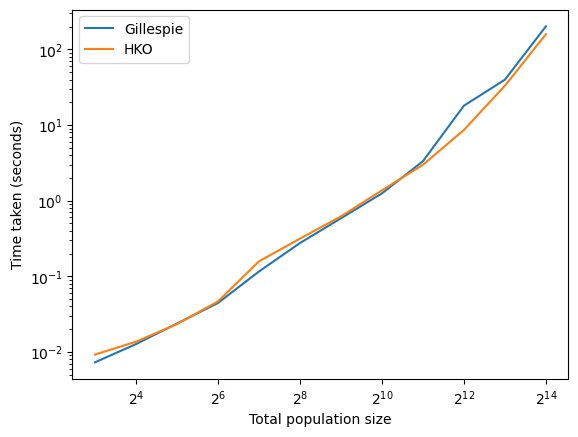

In [8]:
Population_graph_series = []
for i in Population_series:
    Population_graph_series = np.append(Population_graph_series, i[0] * 2)
plt.errorbar(Population_graph_series, Gillespie_data[1], label = 'Gillespie')
plt.errorbar(Population_graph_series, HKO_data[1], label = 'HKO')
plt.ylabel ('Time taken (seconds)')
plt.xlabel ('Total population size')
plt.xscale("log", base = 2)
plt.yscale("log")
plt.legend()
plt.savefig('Efficiency study (2 classes)')
plt.show()

Below we see the average time taken for a population of size $2^{14}$

In [14]:
print(Gillespie_data[1][-1])
print(HKO_data[1][-1])

202.19830935401376
158.88923922801857


And the standard deviation

In [10]:
print(np.sqrt(Gillespie_data[3][-1]))
print(np.sqrt(HKO_data[3][-1]))

12.98550884396579
14.814216057725467


Below we have histograms for the time taken for all our runs of the HKO and Gillespie algorithm at population size $2^{14}$

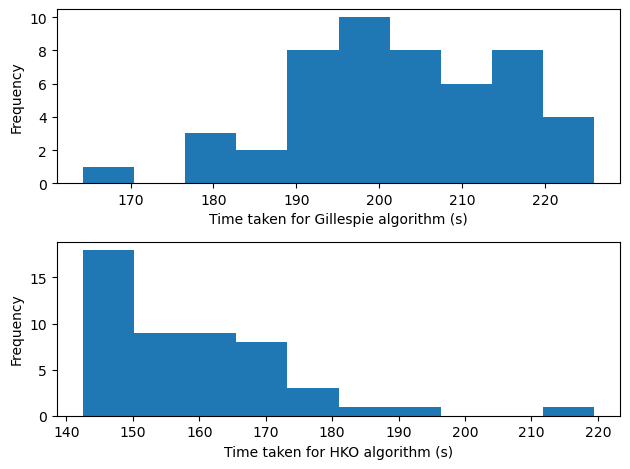

In [15]:
plt.subplot(2, 1, 1)
plt.hist(Gillespie_data[4][-50:,], bins = 10)
plt.ylabel ('Frequency')
plt.xlabel ('Time taken for Gillespie algorithm (s)')
plt.subplot(2, 1, 2)
plt.hist(HKO_data[4][-50:,], bins = 10)
plt.ylabel ('Frequency')
plt.xlabel ('Time taken for HKO algorithm (s)')
plt.tight_layout()
plt.savefig('Histograms efficiency study (2 classes)')
plt.show()